In [1]:
# this code can read data and metadata in 384-well format and do the math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ask user how the data should be called
data_name = input("How should the data be named? ")

# get current location and create an output folder
current_path = os.getcwd() + "/"
folder_path = current_path + "output/"
if not os.path.exists(folder_path):
    output_folder = os.makedirs(folder_path)
    print(f"Folder created at {folder_path}")
else: print(f"Folder already exists at {folder_path}")    

# size and resolution of the graphs    
fig_size_bar = (10, 20) # width, height in inch
fig_size_heat = (20, 10)
dpi = 400

How should the data be named? test
Folder already exists at /Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/output/


In [2]:
# Read the data from a CSV file
data = pd.read_csv('data.csv', sep=';', index_col=0)
metadata = pd.read_csv('metadata.csv', sep=',', index_col=0)

# Transpose the DataFrame
data_T = data.T
metadata_T = metadata.T

# Reset the index and rename the columns
data_T = data_T.reset_index()
data_T = data_T.rename(columns={'index': 'well'})
meatadata_T = metadata_T.reset_index()
metadata_T = meatadata_T.rename(columns={'index': 'well'})

# Melt the DataFrame to create the desired format
data_T_melt = pd.melt(data_T, id_vars=['well'], var_name='OD')
metadata_T_melt = pd.melt(metadata_T, id_vars=['well'], var_name='condition')

# Combine the 'Well' and 'OD' columns
data_T_melt['well'] = data_T_melt['OD'] + data_T_melt['well']
metadata_T_melt['well'] = metadata_T_melt['condition'] + metadata_T_melt['well']

# Keep only the 'Well_OD' and 'value' columns
data_T_melt = data_T_melt[['well', 'value']]
metadata_T_melt = metadata_T_melt[['well', 'value']]

# Rename the 'value' column to 'OD'
data_T_melt = data_T_melt.rename(columns={'value': 'OD'})
metadata_T_melt = metadata_T_melt.rename(columns={'value': 'condition'})

# merge data and metadata
merged_data = pd.merge(data_T_melt, metadata_T_melt, on = 'well')
# save merged data file to use it in prism:
merged_data.to_csv(os.path.join(folder_path + data_name + 'merged_data.csv'), index=False)
print("saved at: " + os.path.join(folder_path))


saved at: /Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/output/


In [3]:
# visual control of the transformed tables
print("this is data_T_melt: \n ", data_T_melt, "\n")
print("this is metadata: \n ", metadata_T_melt, "\n")
print("this is merged data: \n ", merged_data, "\n")

this is data: 
      well     OD
0     A1  0.988
1     A2  0.985
2     A3  0.902
3     A4  0.956
4     A5  0.968
..   ...    ...
379  P20  0.157
380  P21  0.232
381  P22  0.194
382  P23  0.138
383  P24  0.152

[384 rows x 2 columns] 

this is metadata: 
      well                 condition
0     A1               300 nL DMSO
1     A2               300 nL DMSO
2     A3               300 nL DMSO
3     A4               300 nL DMSO
4     A5               300 nL DMSO
..   ...                       ...
379  P20  300 nL cipro (133 µg/mL)
380  P21  300 nL cipro (133 µg/mL)
381  P22  300 nL cipro (133 µg/mL)
382  P23  300 nL cipro (133 µg/mL)
383  P24  300 nL cipro (133 µg/mL)

[384 rows x 2 columns] 

this is merged data: 
      well     OD                 condition
0     A1  0.988               300 nL DMSO
1     A2  0.985               300 nL DMSO
2     A3  0.902               300 nL DMSO
3     A4  0.956               300 nL DMSO
4     A5  0.968               300 nL DMSO
..   ...    ...       

In [4]:
# remove well column
merged_data = merged_data.drop("well", axis=1)
merged_data = merged_data.sort_values(by='condition', ascending=False)
print(merged_data)

        OD                 condition
383  0.152  300 nL cipro (133 µg/mL)
173  0.121  300 nL cipro (133 µg/mL)
139  0.177  300 nL cipro (133 µg/mL)
140  0.125  300 nL cipro (133 µg/mL)
141  0.123  300 nL cipro (133 µg/mL)
..     ...                       ...
165  0.547               300 nL DMSO
166  0.821               300 nL DMSO
167  0.506               300 nL DMSO
1    0.985               300 nL DMSO
192  0.889               300 nL DMSO

[384 rows x 2 columns]


In [5]:
# Group the merged_data DataFrame by 'Condition' and calculate both mean and standard deviation
# the .agg function calculates both mean and standard deviation
grouped_data = merged_data.groupby('condition').agg({'OD': ['mean', 'std']})

# Reset the index to make 'Condition' a column instead of an index
grouped_data.reset_index(inplace=True)

# Rename the columns for clarity
grouped_data.columns = ['condition', 'mean_OD', 'std_OD']

# Print the resulting DataFrame
print(grouped_data)

                  condition   mean_OD    std_OD
0               300 nL DMSO  0.707333  0.210812
1  300 nL cipro (133 µg/mL)  0.160781  0.050942


In [6]:
# now calculate a z-score
# the .loc function extracts the value from the table at the crossing point of the descriptors
# the .iloc function lets you do the same, but based on integer row and column positions (e.g. 0, 3)
# df.iloc[row_position, column_position], keep in mind that the df is zero-indexed
mean_neg = grouped_data.iloc[1, 1]
mean_pos = grouped_data.iloc[0, 1]
std_neg = grouped_data.iloc[1, 2]
std_pos = grouped_data.iloc[0, 2]
z = 1 - (3*(std_pos+std_neg))/(mean_pos-mean_neg)
print(z)

-0.43676024359431453


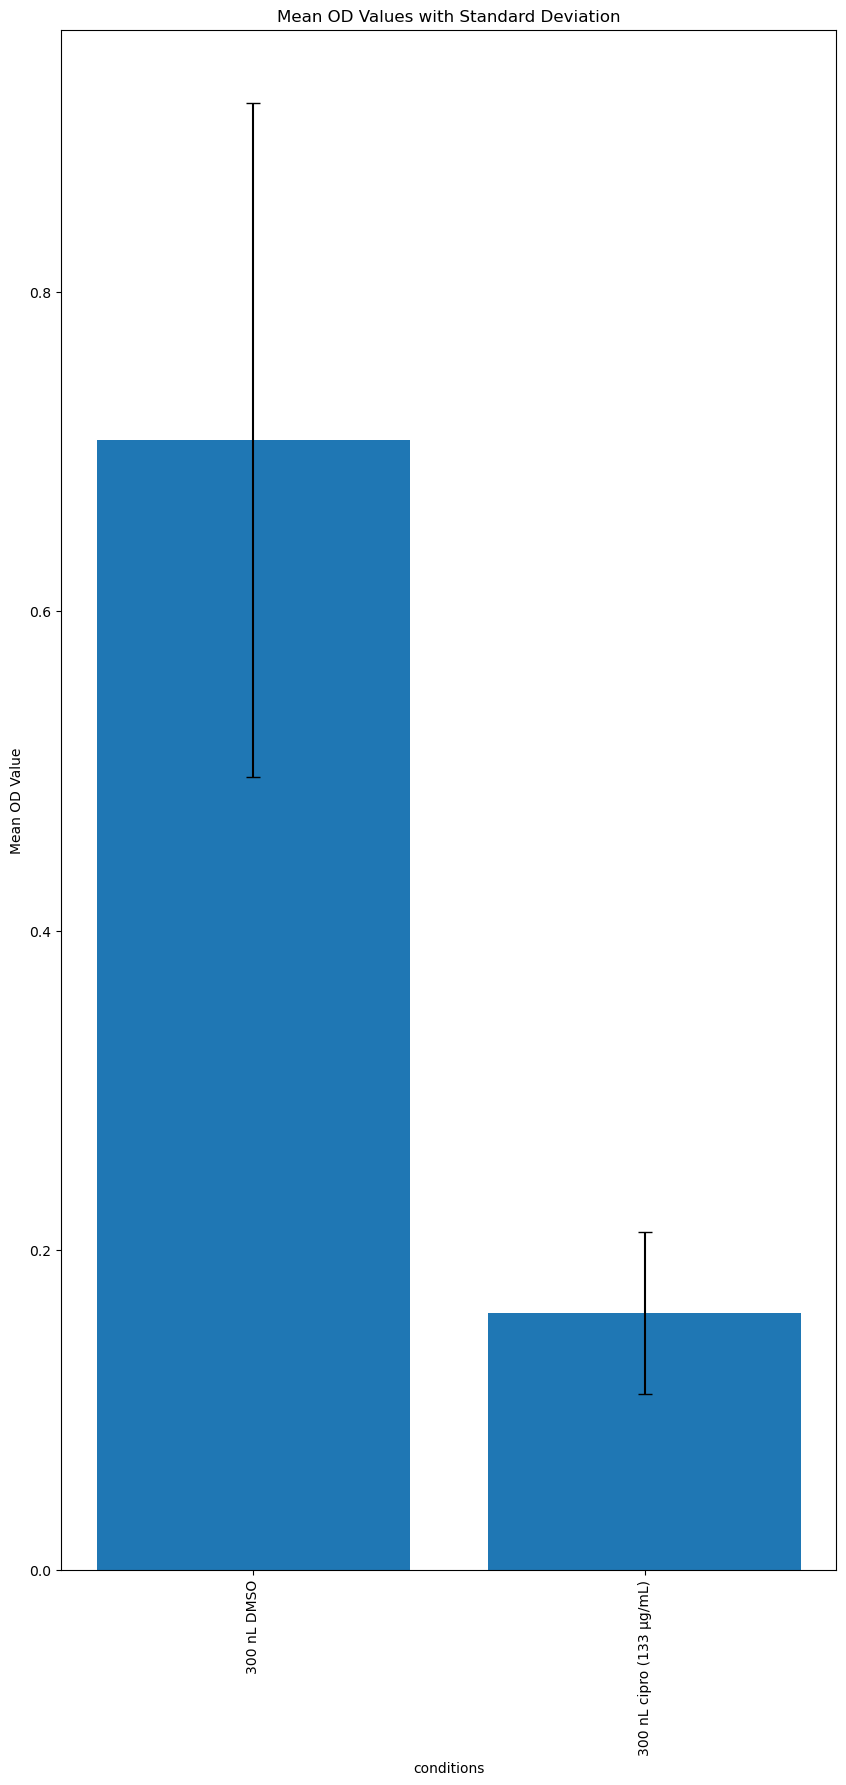

In [7]:
# Plot the mean values
plt.bar(grouped_data['condition'], grouped_data['mean_OD'], yerr=grouped_data['std_OD'], capsize=5)
plt.xlabel('conditions')
plt.ylabel('Mean OD Value')
plt.title('Mean OD Values with Standard Deviation')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.gcf().set_size_inches(fig_size_bar)
plt.savefig(os.path.join(folder_path + 'bar-graph.png'), dpi=dpi) # remember to save figs before plt.show them! It doenst work the other way around
plt.show()

       1      2      3      4      5      6      7      8      9     10  ...  \
A  0.988  0.985  0.902  0.956  0.968  1.009  1.093  0.976  0.815  0.869  ...   
B  0.236  0.117  0.148  0.173  0.114  0.368  0.118  0.125  0.132  0.125  ...   
C  0.972  0.801  0.762  0.722  0.760  1.022  0.869  1.143  0.749  0.965  ...   
D  0.107  0.203  0.115  0.121  0.135  0.123  0.123  0.131  0.127  0.127  ...   
E  0.603  0.754  0.662  0.683  0.713  0.893  0.832  0.877  0.856  0.822  ...   
F  0.141  0.165  0.121  0.121  0.165  0.125  0.122  0.169  0.130  0.131  ...   
G  0.818  0.691  0.689  0.721  0.780  0.928  0.846  0.876  0.862  0.831  ...   
H  0.134  0.146  0.128  0.176  0.123  0.121  0.121  0.190  0.124  0.134  ...   
I  0.889  0.853  0.718  0.797  0.816  0.997  0.940  1.095  0.955  0.984  ...   
J  0.125  0.122  0.123  0.123  0.124  0.126  0.135  0.125  0.129  0.133  ...   
K  0.870  0.771  0.870  0.789  0.806  0.911  1.034  0.673  1.045  0.933  ...   
L  0.243  0.252  0.268  0.218  0.127  0.

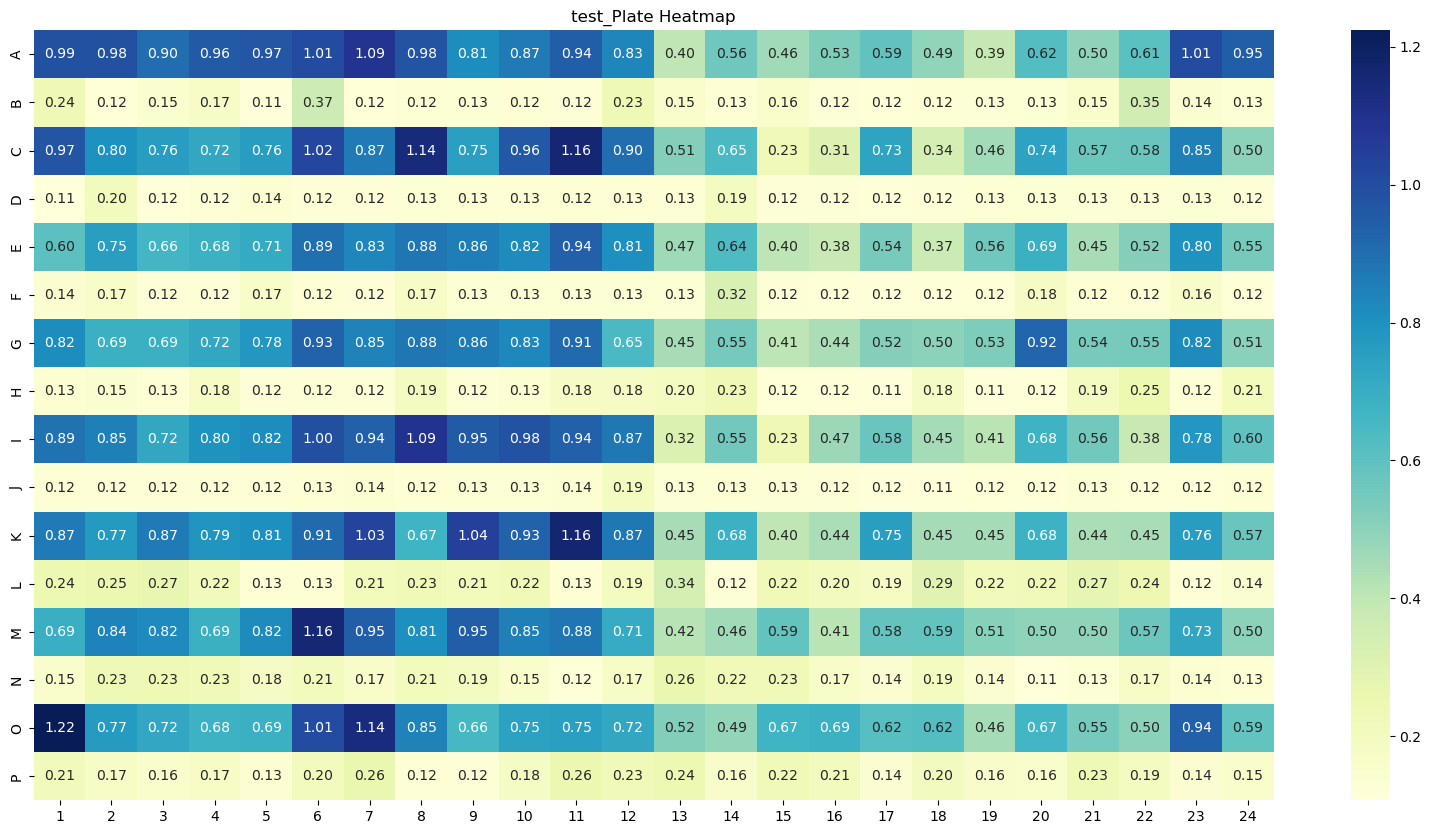

In [9]:
# Generate Heat Map of data file
print(data)
plt.figure(figsize=fig_size_heat)
sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True, square=False)
plt.title(data_name + '_Plate Heatmap')
plt.savefig(os.path.join(folder_path + 'heat-map.png'), dpi=dpi)
plt.show()